In [1]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import os
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import pylab
from plotly.offline import iplot
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as pyo
import scipy.stats as stats
import time
import yfinance as yf

from collections import defaultdict
from datetime import date
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from pylab import rcParams
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
import xgboost
import lightgbm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from tqdm.notebook import tqdm_notebook

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

%matplotlib inline

In [8]:
need_row_data = False
load_data = False

seed = 42

period = '6y'
interval = '1d'

N = 10 

train_size = 0.9          # split data into train, validation, and test with ratio of 0.7, 0.15, 0.15
val_size = 0.9

# Load data

In [9]:
if need_row_data:
    csvs = [
        '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'
    ]

    tickers = pd.DataFrame()
    for csv in csvs:
        data = pd.read_csv(f'data/row_jap/{csv}.csv')
        tickers = pd.concat([tickers, data], axis=0)

    #with open('models/row_jap_stock.pickle', 'wb') as handle:
    #    pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)

    tickers = tickers[['ｺｰﾄﾞ', '会社名', '業種', '時価総額\r\n(10億円)']]
    tickers.rename(columns={"ｺｰﾄﾞ": "ticker", "会社名": "company", "業種":"sector", "時価総額\r\n(10億円)": "market_cap"}, inplace=True)
    tickers.replace(',','', regex=True, inplace=True)
    tickers['market_cap'] = tickers['market_cap'].astype(str).astype(int)

    with open('data/jap_ticker.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('data/jap_ticker.pickle', 'rb') as handle:
        tickers = pickle.load(handle)

tickers.head()

,ticker,company,sector,market_cap
0,7203,トヨタ自動車,自動車・自動車部品,33576
1,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上,その他金融,15764
2,9432,日本電信電話,通信,13858
3,6758,ソニーグループ,電気機器,13658
4,6861,キーエンス,電気機器,11667


In [10]:
dji_data = yf.download(tickers='^dji', period=period, interval=interval, progress=False)
dji_data.rename({"Adj Close": 'dji'}, inplace=True, axis=1)
dji_data.tail()

,Open,High,Low,Close,dji,Volume
Date,,,,,,
2022-07-07,31190.650391,31421.839844,31154.640625,31384.550781,31384.550781,296620000
2022-07-08,31348.429688,31511.460938,31212.449219,31338.150391,31338.150391,238120000
2022-07-11,31277.980469,31367.550781,31114.400391,31173.839844,31173.839844,245020000
2022-07-12,31113.310547,31346.099609,30860.509766,30981.330078,30981.330078,324190000
2022-07-13,30743.630859,30979.169922,30514.609375,30908.160156,30908.160156,208558348


In [11]:
if load_data:
    dfs = []

    forex_data = yf.download('USDJPY=X', period=period, interval=interval, progress=False)
    forex_data.rename({"Adj Close": 'forex'}, inplace=True, axis=1)
    forex = forex_data[['forex']]

    dji_data = yf.download('^dji', period=period, interval=interval, progress=False)
    dji_data.rename({"Adj Close": 'dji'}, inplace=True, axis=1)
    dji = dji_data[['dji']]#.shift(1)

    for i, company in tqdm_notebook(tickers.iterrows()):
        ticker = str(company["ticker"]) + '.T'
        try:
            temp_df = yf.download(ticker, period=period, interval=interval, progress=False)
            # create ticker column and sector column
            temp_df = pd.concat([temp_df, forex, dji], axis=1, join='inner')
            temp_df['ticker'] = ticker
            temp_df['sector'] = company["sector"]

            dfs.append(temp_df)
        except Exception as e: print(e)

else:
    with open('data/jp_company_data.pickle', 'rb') as handle:
        dfs = pickle.load(handle)

dfs[0].head()

,Open,High,Low,Close,Adj Close,Volume,forex,dji,ticker,sector
Date,,,,,,,,,,
2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,104.755997,18372.119141,7203.T,自動車・自動車部品
2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998413,57826000,104.075996,18506.410156,7203.T,自動車・自動車部品
2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214539,68174000,105.191002,18516.550781,7203.T,自動車・自動車部品
2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.092102,50186500,106.146004,18559.009766,7203.T,自動車・自動車部品
2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696045,38045500,106.137001,18595.029297,7203.T,自動車・自動車部品


In [12]:
#with open('data/jp_company_data_2022_7_7.pickle', 'wb') as handle:
#    pickle.dump(dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
remove_df_i = []

for i, temp_df in enumerate(dfs):
    if temp_df.shape[0] == 0:
        print(temp_df.ticker)
        remove_df_i.append(i)
        continue
    temp_df.reset_index(inplace=True)
    # Change all column headings to be lower case, and remove spacing
    temp_df.columns = [str(x).lower().replace(' ', '_') for x in temp_df.columns]

    # Sort by datetime
    temp_df.sort_values(by='date', inplace=True, ascending=True)

    # Create returns column
    temp_df['daily_ret'] = 100.0 * ((temp_df['adj_close'].shift(-1) / temp_df['adj_close'])-1)

    # create weekday column
    date = pd.to_datetime(temp_df['date']).dt
    temp_df['weekday'] = date.weekday
    temp_df['month'] = date.month
    temp_df['year'] = date.year

for index in sorted(remove_df_i, reverse=True):
    del dfs[index]

dfs[0].tail()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year
1426,2022-07-06,2089.0,2098.0,2043.5,2058.0,2058.0,32025100,135.520996,31037.679688,7203.T,自動車・自動車部品,2.283771,2,7,2022
1427,2022-07-07,2086.5,2108.0,2065.0,2105.0,2105.0,27506300,135.966003,31384.550781,7203.T,自動車・自動車部品,0.285036,3,7,2022
1428,2022-07-08,2120.5,2147.0,2108.0,2111.0,2111.0,35446600,135.912994,31338.150391,7203.T,自動車・自動車部品,1.942207,4,7,2022
1429,2022-07-11,2140.0,2158.5,2134.0,2152.0,2152.0,28062000,136.300995,31173.839844,7203.T,自動車・自動車部品,-1.649628,0,7,2022
1430,2022-07-12,2152.0,2153.0,2110.5,2116.5,2116.5,24129000,137.388000,30981.330078,7203.T,自動車・自動車部品,NaN,1,7,2022


In [ ]:
temp_dfs = pd.concat(dfs)
temp_dfs.head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,sector,daily_ret,weekday,month,year
0,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203186,71689000,102.524002,18347.669922,7203.T,自動車・自動車部品,3.398854,1,7,2016
1,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,104.755997,18372.119141,7203.T,自動車・自動車部品,0.355395,2,7,2016
2,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998657,57826000,104.075996,18506.410156,7203.T,自動車・自動車部品,1.965293,3,7,2016
3,2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214600,68174000,105.191002,18516.550781,7203.T,自動車・自動車部品,0.434086,4,7,2016
4,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.091919,50186500,106.146004,18559.009766,7203.T,自動車・自動車部品,-0.155593,1,7,2016


In [ ]:
# Generate Gaussian curve to fit the daily returns
mu = temp_dfs['daily_ret'].mean()
std = temp_dfs['daily_ret'].std()
x = np.arange(temp_dfs['daily_ret'].min(), temp_dfs['daily_ret'].max(), 0.001)
y = [1/math.sqrt(2*math.pi)/std*math.exp(-((i-mu)**2)/2/(std**2)) for i in x]
gauss_df = pd.DataFrame({'x':x, 'y':y})
print("meam = " + str(mu) + ", std dev = " + str(std))

meam = 0.08280362369822417, std dev = 15.289003061689796


/var/folders/kx/kj70wzv55d30dqrqqm60c3t80000gn/T/ipykernel_80012/1427233749.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



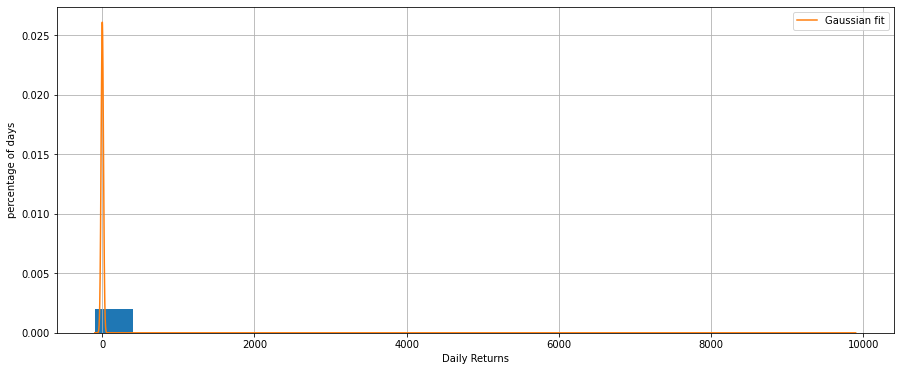

In [ ]:
# Plot histogram of the daily returns
temp_dfs = temp_dfs[abs(temp_df['daily_ret'])<=1000]
ax = temp_dfs['daily_ret'].hist(bins=20, density=True)
gauss_df.plot(x='x', y='y', grid=True, ax=ax, figsize=(15,6))
plt.xlabel('Daily Returns')
plt.ylabel('percentage of days')
plt.legend(['Gaussian fit'])

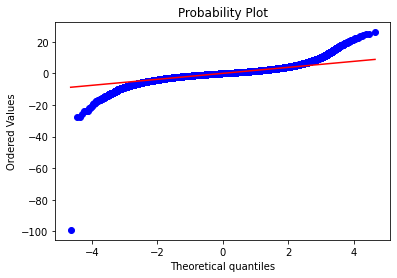

In [ ]:
# Plot QQ plot
temp_dfs = temp_dfs[abs(temp_dfs['daily_ret']) <= 500]
stats.probplot(temp_dfs['daily_ret'].fillna(0), dist="norm", plot=pylab)
pylab.show()

In [ ]:
# Plot with plotly
data = [
    go.Scatter(
        x = temp_df['date'],
        y = temp_df['adj_close']/temp_df['adj_close'].min(),
        mode = 'lines')
    for temp_df in dfs[:10]
    ]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'ratio'))

fig = dict(data=data, layout=layout)
iplot(fig)

# Feature Engineering

## Simple Moving Average

In [14]:
# Simple moving average
for temp_df in dfs:
    temp_df['sma_10'] = temp_df['adj_close'].rolling(window = 10).mean()
    temp_df['sma_20'] = temp_df['adj_close'].rolling(window = 20).mean()
    temp_df['sma_50'] = temp_df['adj_close'].rolling(window = 50).mean()
    temp_df['sma_100'] = temp_df['adj_close'].rolling(window = 100).mean()
    temp_df['sma_200'] = temp_df['adj_close'].rolling(window = 200).mean()

    # Get the sma on the previous day
    temp_df['adj_close_lag_1'] = temp_df['adj_close'].shift(1)
    temp_df['sma_10_lag_1'] = temp_df['sma_10'].shift(1)
    temp_df['sma_20_lag_1'] = temp_df['sma_20'].shift(1)
    temp_df['sma_50_lag_1'] = temp_df['sma_50'].shift(1)
    temp_df['sma_100_lag_1'] = temp_df['sma_100'].shift(1)
    temp_df['sma_200_lag_1'] = temp_df['sma_200'].shift(1)

    # Get above signals
    temp_df['sma_above20'] = (temp_df['adj_close'] > temp_df['sma_20']).astype(int)
    temp_df['sma_above50'] = (temp_df['adj_close'] > temp_df['sma_50']).astype(int)
    temp_df['sma_above100'] = (temp_df['adj_close'] > temp_df['sma_100']).astype(int)
    temp_df['sma_above200'] = (temp_df['adj_close'] > temp_df['sma_200']).astype(int)

    temp_df['sma_10above20'] = (temp_df['sma_10'] > temp_df['sma_20']).astype(int)
    temp_df['sma_10above50'] = (temp_df['sma_10'] > temp_df['sma_50']).astype(int)
    temp_df['sma_10above100'] = (temp_df['sma_10'] > temp_df['sma_100']).astype(int)
    temp_df['sma_10above200'] = (temp_df['sma_10'] > temp_df['sma_200']).astype(int)

    # Get bullish crossover signals
    temp_df['sma_cut20'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_above20']==True)).astype(int)
    temp_df['sma_cut50'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_above50']==True)).astype(int)
    temp_df['sma_cut100'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_above100']==True)).astype(int)
    temp_df['sma_cut200'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_above200']==True)).astype(int)

    temp_df['sma_10cut20'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_10above20']==True)).astype(int)
    temp_df['sma_10cut50'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_10above50']==True)).astype(int)
    temp_df['sma_10cut100'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_10above100']==True)).astype(int)
    temp_df['sma_10cut200'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_10above200']==True)).astype(int)

    # Get bearish crossover signals
    temp_df['sma_cut20down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['adj_close'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_cut50down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['adj_close'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_cut100down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['adj_close'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_cut200down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['adj_close'] < temp_df['sma_200'])).astype(int)

    temp_df['sma_10cut20down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['sma_10'] < temp_df['sma_20'])).astype(int)
    temp_df['sma_10cut50down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['sma_10'] < temp_df['sma_50'])).astype(int)
    temp_df['sma_10cut100down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['sma_10'] < temp_df['sma_100'])).astype(int)
    temp_df['sma_10cut200down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['sma_10'] < temp_df['sma_200'])).astype(int)

    dfs[0].head()

In [15]:
# Del unneccesary cols
for df in dfs:
    df.drop(['sma_10', 'sma_50', 'sma_100', 'sma_200',
             'sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1'], axis=1, inplace=True)

## Exponential Moving Average

In [16]:
for df in dfs:
    # Exponential moving average
    df['ema_10'] = df['adj_close'].ewm(span = 10, adjust=False).mean()
    df['ema_20'] = df['adj_close'].ewm(span = 20, adjust=False).mean()
    df['ema_50'] = df['adj_close'].ewm(span = 50, adjust=False).mean()
    df['ema_100'] = df['adj_close'].ewm(span = 100, adjust=False).mean()
    df['ema_200'] = df['adj_close'].ewm(span = 200, adjust=False).mean()

    # Get the ema on the previous day
    df['adj_close_lag_1'] = df['adj_close'].shift(1)
    df['ema_10_lag_1'] = df['ema_10'].shift(1)
    df['ema_20_lag_1'] = df['ema_20'].shift(1)
    df['ema_50_lag_1'] = df['ema_50'].shift(1)
    df['ema_100_lag_1'] = df['ema_100'].shift(1)
    df['ema_200_lag_1'] = df['ema_200'].shift(1)

    # Get above signals
    df['ema_above20'] = (df['adj_close'] > df['ema_20']).astype(int)
    df['ema_above50'] = (df['adj_close'] > df['ema_50']).astype(int)
    df['ema_above100'] = (df['adj_close'] > df['ema_100']).astype(int)
    df['ema_above200'] = (df['adj_close'] > df['ema_200']).astype(int)

    df['ema_10above20'] = (df['ema_10'] > df['ema_20']).astype(int)
    df['ema_10above50'] = (df['ema_10'] > df['ema_50']).astype(int)
    df['ema_10above100'] = (df['ema_10'] > df['ema_100']).astype(int)
    df['ema_10above200'] = (df['ema_10'] > df['ema_200']).astype(int)

    # Get bullish crossover signals
    df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
    df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
    df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
    df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

    df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
    df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
    df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
    df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < df['ema_20'])).astype(int)
    df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < df['ema_50'])).astype(int)
    df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < df['ema_100'])).astype(int)
    df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < df['ema_200'])).astype(int)

    df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (df['ema_10'] < df['ema_20'])).astype(int)
    df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (df['ema_10'] < df['ema_50'])).astype(int)
    df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (df['ema_10'] < df['ema_100'])).astype(int)
    df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (df['ema_10'] < df['ema_200'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down
0,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,104.755997,18372.119141,7203.T,...,0,0,0,0,0,0,0,0,0,0
1,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998413,57826000,104.075996,18506.410156,7203.T,...,0,0,0,0,0,0,0,0,0,0
2,2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214539,68174000,105.191002,18516.550781,7203.T,...,0,0,0,0,0,0,0,0,0,0
3,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.092102,50186500,106.146004,18559.009766,7203.T,...,0,0,0,0,0,0,0,0,0,0
4,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696045,38045500,106.137001,18595.029297,7203.T,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Del unneccesary cols
for df in dfs:
    df.drop(['ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
             'ema_10_lag_1', 'ema_20_lag_1', 'ema_50_lag_1', 'ema_100_lag_1', 'ema_200_lag_1'], axis=1, inplace=True)

## Moving Average Convergence Divergence

Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/m/macd.asp

In [18]:
for df in dfs:
    # Exponential moving average
    df['ema_12'] = df['adj_close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['adj_close'].ewm(span=26, adjust=False).mean()

    # MACD
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Get the macd on the previous day
    df['macd_lag_1'] = df['macd'].shift(1)
    df['macd_signal_lag_1'] = df['macd_signal'].shift(1)

    # Get bullish crossover signals
    df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                            (df['macd'] > df['macd_signal'])).astype(int)

    # Get bearish crossover signals
    df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                            (df['macd'] < df['macd_signal'])).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,ema_10cut100down,ema_10cut200down,ema_12,ema_26,macd,macd_signal,macd_lag_1,macd_signal_lag_1,macd_crossover,macd_crossoverdown
0,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,104.755997,18372.119141,7203.T,...,0,0,872.896423,872.896423,0.000000,0.000000,NaN,NaN,0,0
1,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998413,57826000,104.075996,18506.410156,7203.T,...,0,0,873.373653,873.126200,0.247452,0.049490,0.000000,0.000000,0,0
2,2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214539,68174000,105.191002,18516.550781,7203.T,...,0,0,876.426097,874.614225,1.811871,0.401967,0.247452,0.049490,0,0
3,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.092102,50186500,106.146004,18559.009766,7203.T,...,0,0,879.605482,876.279253,3.326229,0.986819,1.811871,0.401967,0,0
4,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696045,38045500,106.137001,18595.029297,7203.T,...,0,0,882.080953,877.717534,4.363419,1.662139,3.326229,0.986819,0,0


In [19]:
for df in dfs:
    # Del unneccesary cols
    df.drop(['ema_12', 'ema_26', 'macd_signal', 'macd_lag_1', 'macd_signal_lag_1'], axis=1, inplace=True)

## Stochastic Oscillator
Implemented according to the definition in Investopedia:
https://www.investopedia.com/terms/s/stochasticoscillator.asp#:~:text=A%20stochastic%20oscillator%20is%20a,moving%20average%20of%20the%20result.

In [20]:
for df in dfs:
    # Generate fast and slow stochastic oscillators
    df['lowest_14'] = df['close'].rolling(window = 14).min()
    df['highest_14'] = df['close'].rolling(window = 14).max()
    df['stochastic_fast'] = 100.0*(df['close'] - df['lowest_14'])/(df['highest_14'] - df['lowest_14'])
    df['stochastic_slow'] = df['stochastic_fast'].rolling(window = 3).mean()

    # Get the stochastics on the previous day
    df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
    df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

    # Get bullish crossover signals
    df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

    # Get bearish crossover signals
    df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)

    # Get overbought/oversold signals
    df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
    df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,lowest_14,highest_14,stochastic_fast,stochastic_slow,stochastic_fast_lag_1,stochastic_slow_lag_1,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb
0,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896423,97297000,104.755997,18372.119141,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998413,57826000,104.075996,18506.410156,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2016-07-15,1135.000000,1161.400024,1133.199951,1151.800049,893.214539,68174000,105.191002,18516.550781,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,2016-07-19,1163.199951,1165.199951,1138.000000,1156.800049,897.092102,50186500,106.146004,18559.009766,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,2016-07-20,1148.000000,1156.800049,1145.800049,1155.000000,895.696045,38045500,106.137001,18595.029297,7203.T,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0


In [21]:
# Del unneccesary cols
for df in dfs:
    df.drop(['lowest_14', 
             'highest_14', 
             'stochastic_fast_lag_1', 
             'stochastic_slow_lag_1'], axis=1, inplace=True)

## Relative Strength Index
Implemented according to:

https://www.investopedia.com/terms/r/rsi.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:relative_strength_index_rsi

In [22]:
for df in dfs:
    # Get gain and loss columns
    df['gain'] = df['daily_ret']
    df.loc[df['gain']<0, 'gain'] = 0

    df['loss'] = df['daily_ret']
    df.loc[df['loss']>0, 'loss'] = 0
    df['loss'] = abs(df['loss'])

    # Get avg_gain, avg_loss columns
    df['avg_gain'] = df['gain'].rolling(window = 14, min_periods=1).mean()
    df['avg_loss'] = df['loss'].rolling(window = 14, min_periods=1).mean()

    for index, row in df[15:].iterrows():
        df.loc[index, 'avg_gain'] = (df.loc[index-1, 'avg_gain']*13 + row['gain'])/14
        df.loc[index, 'avg_loss'] = (df.loc[index-1, 'avg_loss']*13 + row['loss'])/14

    # Calc RSI
    df['rsi'] = 100 - 100/(1+(df['avg_gain']/df['avg_loss']))
    df['rsi_ob'] = (df['rsi'] > 70).astype(int)
    df['rsi_os'] = (df['rsi'] < 30).astype(int)

dfs[0][20:25]

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb,gain,loss,avg_gain,avg_loss,rsi,rsi_ob,rsi_os
20,2016-08-12,1200.000000,1206.000000,1196.800049,1200.000000,930.593384,41309500,101.807999,18576.470703,7203.T,...,0,0,1,0.000000,0.833340,0.826163,0.567445,59.282327,0,0
21,2016-08-15,1200.000000,1201.400024,1190.000000,1190.000000,922.838379,27639500,101.282997,18636.050781,7203.T,...,1,0,0,0.000000,1.260501,0.767152,0.616949,55.426010,0,0
22,2016-08-16,1194.400024,1200.400024,1173.199951,1175.000000,911.205994,49875500,101.239998,18552.019531,7203.T,...,0,0,0,2.229778,0.000000,0.871625,0.572881,60.340696,0,0
23,2016-08-17,1179.599976,1206.599976,1176.400024,1201.199951,931.523865,46661500,100.199997,18573.939453,7203.T,...,0,0,1,0.000000,1.764916,0.809366,0.658026,55.156755,0,0
24,2016-08-18,1187.000000,1196.400024,1180.000000,1180.000000,915.083252,50021000,99.905998,18597.699219,7203.T,...,1,0,0,2.135609,0.000000,0.904098,0.611024,59.671603,0,0


In [23]:
dfs[0]['gain'].shape

(1431,)

In [24]:
# Del unneccesary cols
for df in dfs:
    df.drop(['gain', 
             'loss'
            ], axis=1, inplace=True)

## Average True Range
Implemented according to the definition in Investopedia: https://www.investopedia.com/terms/a/atr.asp

In [25]:
for df in dfs:
    # Get atr
    df['close_lag_1'] = df['close'].shift(1)
    df['tr'] = np.maximum(df['high']-df['low'], np.maximum(abs(df['high']-df['close_lag_1']), abs(df['low']-df['close_lag_1'])))
    df['atr'] = df['tr'].rolling(window = 14).mean()
    
    # Get bullish atr signal - buy when next day's price is above yesterday's closing + atr
    df['atr_signal'] = (df['high'] > ((df['close_lag_1'] + df['atr']))).astype(int)
    
    # Get bearish atr signal - sell when next day's price is below yesterday's closing - atr
    df['atr_signaldown'] = (df['low'] < ((df['close_lag_1'] - df['atr']))).astype(int)

In [26]:
# Del unneccesary cols
for df in dfs:
    df.drop(['close_lag_1'], axis=1, inplace=True)  

## Average Directional Index
Implemented according to:

https://www.investopedia.com/terms/a/adx.asp

https://school.stockcharts.com/doku.php?id=technical_indicators:average_directional_index_adx

In [27]:
def comp_pdm(high, high_lag_1, low, low_lag_1):
    if (high-high_lag_1) > (low_lag_1-low):
        return(max(high-high_lag_1, 0))
    else:
        return 0

def comp_mdm(high, high_lag_1, low, low_lag_1):
    if (low_lag_1-low) > (high-high_lag_1):
        return(max(low_lag_1-low, 0))
    else:
        return 0

for i, df in enumerate(dfs):

    # Get +/- directional movement
    df['high_lag_1'] = df['high'].shift(1)
    df['low_lag_1'] = df['low'].shift(1)

    df['+dm'] = df.apply(lambda row: comp_pdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)
    df['-dm'] = df.apply(lambda row: comp_mdm(row['high'], row['high_lag_1'], row['low'], row['low_lag_1']), axis=1)

    # Get smoothed +/- directional movement
    df['smoothed+dm'] = 0
    df.loc[14, 'smoothed+dm'] = df[1:15]['+dm'].sum()
    
    df['smoothed-dm'] = 0
    df.loc[14, 'smoothed-dm'] = df[1:15]['-dm'].sum()
    
    df['14tr'] = 0
    df.loc[14, '14tr'] = df[1:15]['tr'].sum()

    for index, row in df[15:].iterrows():
        df.loc[index, 'smoothed+dm'] = df.loc[index-1, 'smoothed+dm'] - (df.loc[index-1, 'smoothed+dm']/14) + row['+dm']
        df.loc[index, 'smoothed-dm'] = df.loc[index-1, 'smoothed-dm'] - (df.loc[index-1, 'smoothed-dm']/14) + row['-dm']
        df.loc[index, '14tr'] = df.loc[index-1, '14tr'] - (df.loc[index-1, '14tr']/14) + row['tr']
        
    # Get +/- directional index
    df['+di'] = 100.0*(df['smoothed+dm']/df['14tr'])
    df['-di'] = 100.0*(df['smoothed-dm']/df['14tr'])
    
    # Get directional movement index
    df['dx'] = 100.0 * (abs(df['+di']-df['-di'])/abs(df['+di']+df['-di']))
    
    # Get average directional movement index
    df.loc[27, 'adx'] = df[14:28]['dx'].mean()
    for index, row in df[28:].iterrows():
        df.loc[index, 'adx'] = (df.loc[index-1, 'adx']*13 + row['dx'])/14

    # Get adx strength and trendless
    df['adx_strength'] = (df['adx'] > 25).astype(int)
    df['adx_trendless'] = (df['adx'] < 20).astype(int)
    
    # Get adx signals
    df['+di_lag_1'] = df['+di'].shift(1)
    df['-di_lag_1'] = df['-di'].shift(1)
    df['adx_bull'] = ((df['+di_lag_1'] < df['-di_lag_1']) & (df['+di'] > df['-di']) & (df['adx_strength']==True)).astype(int)
    df['adx_bear'] = ((df['-di_lag_1'] < df['+di_lag_1']) & (df['-di'] > df['+di']) & (df['adx_strength']==True)).astype(int)


In [28]:
df = dfs[0]
signals = df[df['adx_bull']==1]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'], 
                         mode='lines', 
                         name='adj_close', 
                         ), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adx'], 
                         mode='lines', 
                         name='adx', 
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[20]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date'], 
                         y=[25]*len(df['date']), 
                         mode='lines', 
                         line=dict(color='#222A2A', dash='dash'),
                         showlegend=False
                         ), row=2, col=1)

# Add signals
n = 0
for n in range(len(signals)):
    fig.add_trace(go.Scatter(x=[signals.iloc[n]['date'], signals.iloc[n]['date']], 
                             y=[min(df['adj_close']),max(df['adj_close'])], 
                             mode='lines',
                             line=dict(color='rgb(166,216,84)', dash='dash'),
                             showlegend=False
                             ), row=1, col=1)
    n = n+1

fig.update_layout(yaxis=dict(title='USD'))
fig.update_xaxes(title_text="date", row=2, col=1)

# py.iplot(fig, filename='VTI_20130102_20181231_adx')

In [29]:
# Del unneccesary cols
for df in dfs:
    df.drop(['+di',
             '-di',
             '+di_lag_1',
             '-di_lag_1',
             'tr', 
             '+dm', 
             '-dm', 
             'smoothed+dm',
             'smoothed-dm',
             '14tr',
             'dx',
             'tr'], axis=1, inplace=True)

## Bollinger Bands

In [30]:
for df in dfs:
    df['std_20'] = df['adj_close'].rolling(window = 20).std()
    df['bollinger_upp'] = df['sma_20'] + 2*df['std_20']
    df['bollinger_low'] = df['sma_20'] - 2*df['std_20']
    
    # Get dist between bollinger bands and the price
    df['bollinger_upp_dist'] = df['bollinger_upp'] - df['adj_close']
    df['bollinger_low_dist'] = df['adj_close'] - df['bollinger_low']
    
    # Get signals
    df['bollinger_ob'] = (df['adj_close'] > df['bollinger_upp']).astype(int)
    df['bollinger_os'] = (df['adj_close'] < df['bollinger_low']).astype(int)


In [31]:
# Del unneccesary cols
for df in dfs:
    df.drop(['std_20', 'bollinger_upp', 'bollinger_low'], axis=1, inplace=True)

In [32]:
# Check if all signals true on any day
df = dfs[0]
df[(df['macd_crossover']==1) & 
   (df['stochastic_fastcutslow']==1) &
   (df['atr_signal']==1) & 
   (df['adx_bull']==1)]

,date,open,high,low,close,adj_close,volume,forex,dji,ticker,...,low_lag_1,adx,adx_strength,adx_trendless,adx_bull,adx_bear,bollinger_upp_dist,bollinger_low_dist,bollinger_ob,bollinger_os


In [33]:
# Remove unnecessary cols
for df in dfs:
    df.drop(['open',
             'high', 
             'low',
             'close',
             'volume',
             'sma_20',
             'adj_close_lag_1',
             'high_lag_1',
             'low_lag_1',
             ], axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1431 entries, 0 to 1430
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1431 non-null   datetime64[ns]
 1   adj_close                   1431 non-null   float64       
 2   forex                       1431 non-null   float64       
 3   dji                         1431 non-null   float64       
 4   ticker                      1431 non-null   object        
 5   sector                      1431 non-null   object        
 6   daily_ret                   1430 non-null   float64       
 7   weekday                     1431 non-null   int64         
 8   month                       1431 non-null   int64         
 9   year                        1431 non-null   int64         
 10  sma_above20                 1431 non-null   int64         
 11  sma_above50                 1431 non-null   int64       

# EDA

In [35]:
def add_lags(df_list, columns, N):
    dfs = [df.copy(deep=True) for df in df_list]
    for df in dfs:
        for col in columns:
            for i in range(1, N):
                df[f'{col}_lag_{i}'] = df[col].shift(i)
    return dfs

In [36]:
# create lag for daily return to N days ahead
dfs_lags = add_lags(dfs, ['daily_ret'], N)
dfs_lags = add_lags(dfs, ['dji'], 5)
dfs_lags[0].shape

(1431, 88)

In [37]:
# Create lags for technical indicators
tech_indicators = list(set(dfs[0].columns) - set(['date', 'daily_ret', 'sector', 'ticker', 'weekday', 'month', 'year', 'dji']))
tech_indicators.sort()

dfs_lags = add_lags(dfs_lags, tech_indicators, 2)
dfs_lags[0].shape

(1431, 164)

In [38]:
#for df in dfs_lags:
#    df.drop([f'{tech_indicator}_lag_1' for tech_indicator in tech_indicators], axis=1, inplace=True)

In [39]:
# Remove columns
for df in dfs_lags:
    df.drop(tech_indicators, axis=1, inplace=True)
dfs_lags[0].shape

(1431, 88)

# Encode Label and delete unnecessary data

In [40]:
dfs_lags[0].tail()

,date,dji,ticker,sector,daily_ret,weekday,month,year,dji_lag_1,dji_lag_2,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1426,2022-07-06,31037.679688,7203.T,自動車・自動車部品,2.283771,2,7,2022,30967.820312,31097.259766,...,0.0,0.0,0.0,0.0,51.196172,1.0,0.0,0.0,0.0,27.119481
1427,2022-07-07,31384.550781,7203.T,自動車・自動車部品,0.285036,3,7,2022,31037.679688,30967.820312,...,1.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,1.0,18.341308
1428,2022-07-08,31338.150391,7203.T,自動車・自動車部品,1.942207,4,7,2022,31384.550781,31037.679688,...,0.0,0.0,0.0,0.0,42.922374,1.0,0.0,0.0,0.0,31.372849
1429,2022-07-11,31173.839844,7203.T,自動車・自動車部品,-1.649628,0,7,2022,31338.150391,31384.550781,...,0.0,0.0,0.0,0.0,48.401826,0.0,0.0,0.0,0.0,30.441400
1430,2022-07-12,30981.330078,7203.T,自動車・自動車部品,NaN,1,7,2022,31173.839844,31338.150391,...,0.0,0.0,1.0,0.0,85.844749,0.0,0.0,1.0,0.0,59.056317


In [41]:
df_lags = pd.concat(dfs_lags)

In [42]:
df_lags.shape

(426934, 88)

In [43]:
df_lags = df_lags[abs(df_lags['daily_ret']) <= 50]
#df_lags.drop(columns=['daily_ret_lag_1'], inplace=True)

In [44]:
# label encode for categorical variables: sector and ticker column
date_encoder = LabelEncoder()
df_lags['date'] = date_encoder.fit_transform(df_lags['date'])

sector_encoder = LabelEncoder()
df_lags['sector'] = sector_encoder.fit_transform(df_lags['sector'])

ticker_encoder = LabelEncoder()
df_lags['ticker'] = ticker_encoder.fit_transform(df_lags['ticker'])
df_lags.head()

,date,dji,ticker,sector,daily_ret,weekday,month,year,dji_lag_1,dji_lag_2,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
0,0,18372.119141,186,21,0.355367,2,7,2016,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,18506.410156,186,21,1.965315,3,7,2016,18372.119141,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,2,18516.550781,186,21,0.434113,4,7,2016,18506.410156,18372.119141,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,3,18559.009766,186,21,-0.155620,1,7,2016,18516.550781,18506.410156,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
4,4,18595.029297,186,21,1.731608,2,7,2016,18559.009766,18516.550781,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [155]:
#with open('v4/jp_date.pickle', 'wb') as handle:
#    pickle.dump(date_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
#with open('v4/jp_sector.pickle', 'wb') as handle:
#    pickle.dump(sector_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
#with open('v4/jp_ticker.pickle', 'wb') as handle:
#    pickle.dump(ticker_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [46]:
pd.set_option('display.max_columns', 100)

In [47]:
# Count number of nulls for each column
df_lags.isnull().sum(axis=0)

date                                   0
dji                                    0
ticker                                 0
sector                                 0
daily_ret                              0
                                    ... 
stochastic_fastcutslow_lag_1         300
stochastic_fastcutslowdown_lag_1     300
stochastic_overb_lag_1               300
stochastic_overs_lag_1               300
stochastic_slow_lag_1               4800
Length: 88, dtype: int64

# Split into train, validation, test

In [48]:
df_lags.dropna(inplace=True)

In [49]:
df_lags.shape

(418232, 88)

In [50]:
df_lags.sort_values('date', inplace=True)

In [51]:
df_lags.tail()

,date,dji,ticker,sector,daily_ret,weekday,month,year,dji_lag_1,dji_lag_2,dji_lag_3,dji_lag_4,adj_close_lag_1,adx_lag_1,adx_bear_lag_1,adx_bull_lag_1,adx_strength_lag_1,adx_trendless_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1,avg_gain_lag_1,avg_loss_lag_1,bollinger_low_dist_lag_1,bollinger_ob_lag_1,bollinger_os_lag_1,bollinger_upp_dist_lag_1,ema_10above100_lag_1,ema_10above20_lag_1,ema_10above200_lag_1,ema_10above50_lag_1,ema_10cut100_lag_1,ema_10cut100down_lag_1,ema_10cut20_lag_1,ema_10cut200_lag_1,ema_10cut200down_lag_1,ema_10cut20down_lag_1,ema_10cut50_lag_1,ema_10cut50down_lag_1,ema_above100_lag_1,ema_above20_lag_1,ema_above200_lag_1,ema_above50_lag_1,ema_cut100_lag_1,ema_cut100down_lag_1,ema_cut20_lag_1,ema_cut200_lag_1,ema_cut200down_lag_1,ema_cut20down_lag_1,ema_cut50_lag_1,ema_cut50down_lag_1,forex_lag_1,macd_lag_1,macd_crossover_lag_1,macd_crossoverdown_lag_1,rsi_lag_1,rsi_ob_lag_1,rsi_os_lag_1,sma_10above100_lag_1,sma_10above20_lag_1,sma_10above200_lag_1,sma_10above50_lag_1,sma_10cut100_lag_1,sma_10cut100down_lag_1,sma_10cut20_lag_1,sma_10cut200_lag_1,sma_10cut200down_lag_1,sma_10cut20down_lag_1,sma_10cut50_lag_1,sma_10cut50down_lag_1,sma_above100_lag_1,sma_above20_lag_1,sma_above200_lag_1,sma_above50_lag_1,sma_cut100_lag_1,sma_cut100down_lag_1,sma_cut20_lag_1,sma_cut200_lag_1,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1429,1429,31173.839844,296,12,-1.525608,0,7,2022,31338.150391,31384.550781,31037.679688,30967.820312,13705.0,23.591895,0.0,0.0,0.0,0.0,369.285714,0.0,0.0,1.002595,0.514773,2113.837897,0.0,0.0,20.337897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.912994,155.230685,0.0,0.0,66.074617,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.044693,0.0,1.0,1.0,0.0,99.348231
1429,1429,31173.839844,34,32,-0.567108,0,7,2022,31338.150391,31384.550781,31037.679688,30967.820312,5100.0,19.762705,0.0,0.0,0.0,1.0,133.571429,0.0,0.0,0.975908,0.548439,512.058478,0.0,0.0,249.221857,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.912994,67.683034,0.0,0.0,64.021368,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.292035,0.0,0.0,0.0,0.0,60.070952
1429,1429,31173.839844,179,14,-3.502870,0,7,2022,31338.150391,31384.550781,31037.679688,30967.820312,5014.0,29.181272,0.0,0.0,1.0,0.0,235.642857,1.0,0.0,1.411968,1.142518,644.751013,0.0,0.0,631.351013,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,135.912994,-38.545214,0.0,0.0,55.274063,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,70.579268,0.0,0.0,0.0,0.0,35.592605
1429,1429,31173.839844,113,9,1.109661,0,7,2022,31338.150391,31384.550781,31037.679688,30967.820312,1516.0,24.027652,0.0,0.0,0.0,0.0,34.000000,0.0,1.0,0.822879,0.465998,160.459438,0.0,0.0,52.359011,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.912994,34.683855,0.0,0.0,63.844643,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.880597,0.0,1.0,0.0,0.0,91.293532
1429,1429,31173.839844,70,9,-4.394141,0,7,2022,31338.150391,31384.550781,31037.679688,30967.820312,2222.0,23.770931,0.0,0.0,0.0,0.0,90.428571,0.0,0.0,0.801790,1.171471,114.233927,0.0,0.0,517.733927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.912994,-74.037325,0.0,0.0,40.632755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.726027,1.0,0.0,0.0,1.0,6.760528


In [52]:
# split train, val, test with ratio of 0.7, 0.15, 0.15
X = df_lags.drop(['daily_ret'], axis=1)
y = df_lags['daily_ret']

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=train_size)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, train_size=val_size)

X_train_val = pd.concat([X_train, X_valid])
y_train_val = pd.concat([y_train, y_valid])

print("train.shape = " + str(X_train.shape))
print("val.shape = " + str(X_valid.shape))
print("train_val.shape = " + str(X_train_val.shape))
print("test.shape = " + str(X_test.shape))

train.shape = (376408, 87)
val.shape = (37641, 87)
train_val.shape = (414049, 87)
test.shape = (4183, 87)


## save in pickle

In [53]:
with open('v4/X_train.pickle', 'wb') as handle:
    pickle.dump(X_train, handle)

with open('v4/X_valid.pickle', 'wb') as handle:
    pickle.dump(X_valid, handle)

with open('v4/X_test.pickle', 'wb') as handle:
    pickle.dump(X_test, handle)

with open('v4/X_train_val.pickle', 'wb') as handle:
    pickle.dump(X_train_val, handle)

with open('v4/y_train.pickle', 'wb') as handle:
    pickle.dump(y_train, handle)

with open('v4/y_valid.pickle', 'wb') as handle:
    pickle.dump(y_valid, handle)

with open('v4/y_test.pickle', 'wb') as handle:
    pickle.dump(y_test, handle)

with open('v4/y_train_val.pickle', 'wb') as handle:
    pickle.dump(y_train_val, handle)

# Reduce Dimension and Standardize

In [121]:
#pca = PCA(n_components=13)
#pca.fit(X_train)

with open('v4/pca.pickle', 'rb') as handle:
    pca = pickle.load(handle)

In [122]:
np.cumsum(pca.explained_variance_ratio_)

array([0.95970548, 0.99533409, 0.99824958, 0.99975956, 0.99984446,
       0.99991483, 0.9999476 , 0.99996672, 0.99997858, 0.99998982,
       0.999997  , 0.9999992 , 0.99999988])

In [123]:
#with open('v4/pca.pickle', 'wb') as handle:
#    pickle.dump(pca, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [124]:
X_train_pca = pca.transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)
X_train_val_pca = pca.transform(X_train_val)

In [125]:
#sc = StandardScaler()
#sc.fit(X_train_pca)

with open('v4/sc.pickle', 'rb') as handle:
    sc = pickle.load(handle)

X_train_std = sc.transform(X_train_pca)
X_valid_std = sc.transform(X_valid_pca)
X_test_std = sc.transform(X_test_pca)
X_train_val_std = sc.transform(X_train_val_pca)

In [120]:
#with open('v4/sc.pickle', 'wb') as handle:
#    pickle.dump(sc, handle, protocol=pickle.HIGHEST_PROTOCOL)

## save in pickle

In [151]:
#with open('v4/X_train_std.pickle', 'wb') as handle:
#    pickle.dump(X_train_std, handle)
#
#with open('v4/X_valid_std.pickle', 'wb') as handle:
#    pickle.dump(X_valid_std, handle)
#
#with open('v4/X_test_std.pickle', 'wb') as handle:
#    pickle.dump(X_test_std, handle)
#
#with open('v4/X_train_val_std.pickle', 'wb') as handle:
#    pickle.dump(X_train_val_std, handle)
#
#with open('v4/y_train.pickle', 'wb') as handle:
#    pickle.dump(y_train, handle)
#
#with open('v4/y_valid.pickle', 'wb') as handle:
#    pickle.dump(y_valid, handle)
#
#with open('v4/y_test.pickle', 'wb') as handle:
#    pickle.dump(y_test, handle)
#
#with open('v4/y_train_val.pickle', 'wb') as handle:
#    pickle.dump(y_train_val, handle)

# get data from pickle

In [2]:
#with open('v4/X_train_std.pickle', 'rb') as handle:
#    X_train_std = pickle.load(handle)
#
#with open('v4/y_train.pickle', 'rb') as handle:
#    y_train = pickle.load(handle)
#    
#with open('v4/X_train_val_std.pickle', 'rb') as handle:
#    X_train_val_std = pickle.load(handle)
#
#with open('v4/y_train_val.pickle', 'rb') as handle:
#    y_train_val = pickle.load(handle)
#
#with open('v4/X_valid_std.pickle', 'rb') as handle:
#    X_valid_std = pickle.load(handle)
#
#with open('v4/y_valid.pickle', 'rb') as handle:
#    y_valid = pickle.load(handle)
#
#with open('v4/X_test_std.pickle', 'rb') as handle:
#    X_test_std = pickle.load(handle)
#
#with open('v4/y_test.pickle', 'rb') as handle:
#    y_test = pickle.load(handle)

# Regression models

In [60]:
tech_indicators = [
    'sma_above20',
    'sma_above50',
    'sma_above100',
    'sma_above200',
    'sma_10above20',
    'sma_10above50',
    'sma_10above100',
    'sma_10above200',
    'sma_cut20',
    'sma_cut50',
    'sma_cut100',
    'sma_cut200',
    'sma_10cut20',
    'sma_10cut50',
    'sma_10cut100',
    'sma_10cut200',
    'sma_cut20down',
    'sma_cut50down',
    'sma_cut100down',
    'sma_cut200down',
    'sma_10cut20down',
    'sma_10cut50down',
    'sma_10cut100down',
    'sma_10cut200down',
    'ema_above20',
    'ema_above50',
    'ema_above100',
    'ema_above200',
    'ema_10above20',
    'ema_10above50',
    'ema_10above100',
    'ema_10above200',
    'ema_cut20',
    'ema_cut50',
    'ema_cut100',
    'ema_cut200',
    'ema_10cut20',
    'ema_10cut50',
    'ema_10cut100',
    'ema_10cut200',
    'ema_cut20down',
    'ema_cut50down',
    'ema_cut100down',
    'ema_cut200down',
    'ema_10cut20down',
    'ema_10cut50down',
    'ema_10cut100down',
    'ema_10cut200down',
    'macd',
    'macd_crossover',
    'macd_crossoverdown',
    'stochastic_fast',
    'stochastic_slow',
    'stochastic_fastcutslow',
    'stochastic_fastcutslowdown',
    'stochastic_overs',
    'stochastic_overb',
    'rsi',
    'rsi_ob',
    'rsi_os',
    'bollinger_upp_dist',
    'bollinger_low_dist',
    'bollinger_ob',
    'bollinger_os'
]

In [61]:
def get_error_metrics(y_pred, y_valid):
    mae = mean_absolute_error(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    rmse = mean_squared_error(y_valid, y_pred)

    print("RMSE = %0.3f" % rmse)
    print("MAPE = %0.3f%%" % mape)
    print("MAE = %0.3f" % mae)

In [62]:
def show_prediction_scatter(y_pred, y_valid):
    fig, ax = plt.subplots()

    ax.set_xlabel("predicted daily returns")
    ax.set_ylabel("actural daily returns")
    ax.scatter(y_pred, y_valid)

    # y = x
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.plot(lims, [0,0], 'r-', alpha=0.75)
    ax.plot([0,0], lims, 'r-', alpha=0.75)

    ax.set_aspect('equal')

## Linear Regression

In [62]:
linear = LinearRegression()
linear.fit(X_train_std, y_train)
linear.score(X_valid_std, y_valid)

0.056216943844537015

In [63]:
y_pred = linear.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 3.540
MAPE = 34490339147924.078%
MAE = 1.301


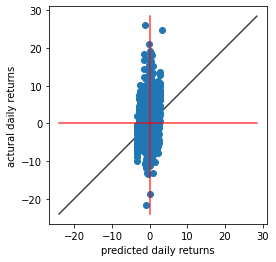

In [64]:
show_prediction_scatter(y_pred, y_valid)

## Random Forest

In [74]:
rf = RandomForestRegressor()
rf.fit(X_train_std, y_train)
rf.score(X_valid_std, y_valid)

0.3728690828698218

In [440]:
#with open('models/jp_rf_2022_7_6.pickle', 'wb') as handle:
#    pickle.dump(rf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
y_pred = rf.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 2.352
MAPE = 58869383606746.945%
MAE = 1.032


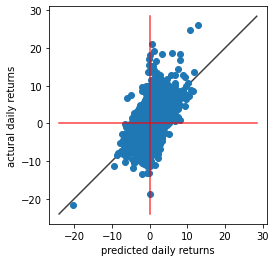

In [76]:
show_prediction_scatter(y_pred, y_valid)

## XGBOOST

In [744]:
xgb = xgboost.XGBRegressor(booster='gbtree')
xgb.fit(X_train_std, y_train)
xgb.score(X_valid_std, y_valid)

0.3031237711963257

In [432]:
#with open('models/jp_xgboost_2022_7_6.pickle', 'wb') as handle:
#    pickle.dump(xgb, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [745]:
y_pred = xgb.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 2.664
MAPE = 51145275215709.555%
MAE = 1.098


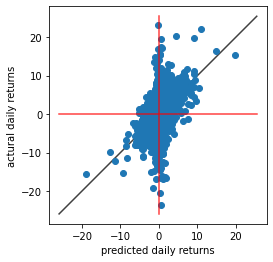

In [746]:
show_prediction_scatter(y_pred, y_valid)

## LightGBM

In [65]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(X_train_std, y_train)
r2_score(y_valid, lgbm.predict(X_valid_std))

0.2707487759428683

In [436]:
#from sklearn.model_selection import RepeatedKFold, cross_val_score
#
#lgbm = lightgbm.LGBMRegressor()
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#cv_score = cross_val_score(
#    lgbm, X_train_val_std, y_train_val,
#    scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
#print('MAE: %.3f (%.3f)' % (np.mean(cv_score), np.std(cv_score)))


In [66]:
y_pred = lgbm.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 2.735
MAPE = 45414018427291.758%
MAE = 1.137


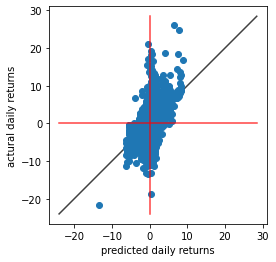

In [67]:
show_prediction_scatter(y_pred, y_valid)

## MLP

In [73]:
solver = "sgd"
random_state = 0
max_iter = 10000

clf = MLPRegressor(
    solver=solver,
    random_state=random_state,
    max_iter=max_iter)

In [74]:
clf.fit(X_train_std, y_train)
r2_score(y_valid, clf.predict(X_valid_std))

/Users/ryuseitaniguchi/Downloads/stock/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning:

Training interrupted by user.



0.002148480209822612

In [ ]:
y_pred = clf.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 7.409
MAPE = 14615008990116.193%
MAE = 1.902


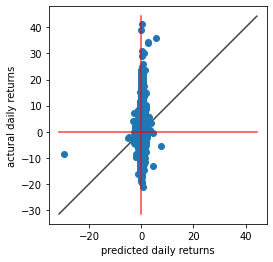

In [ ]:
show_prediction_scatter(y_pred, y_valid)

## SGD Regressor

In [68]:
sgd = SGDRegressor()
sgd.fit(X_train_std, y_train)
sgd.score(X_valid_std, y_valid)

0.046690747726655935

In [69]:
y_pred = sgd.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 3.575
MAPE = 34864288960842.805%
MAE = 1.306


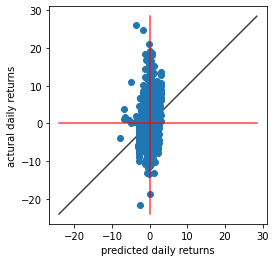

In [70]:
show_prediction_scatter(y_pred, y_valid)

## Lasso Regressor

In [71]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_std, y_train)
lasso.score(X_valid_std, y_valid)

0.04483803545648446

In [72]:
y_pred = lasso.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 3.582
MAPE = 22771080446107.680%
MAE = 1.308


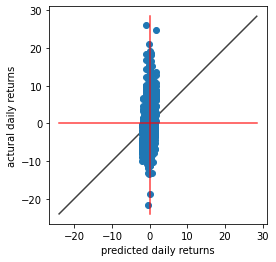

In [73]:
show_prediction_scatter(y_pred, y_valid)

## CNN

In [732]:
model = Sequential()
model.add(Conv1D(5, 2, activation="relu", input_shape=(X_train_std.shape[1], 1)))
model.add(Flatten())
model.add(Dense(10, activation="relu"))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 7, 5)              15        
                                                                 
 flatten_2 (Flatten)         (None, 35)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                360       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


In [734]:
model.fit(X_train_std, y_train, batch_size=10,epochs=10, verbose=0)
r2_score(y_valid, model.predict(X_valid_std))

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

In [ ]:
show_prediction_scatter(y_pred, y_valid)

## NN

In [137]:
with open('v4/keras2.pickle', 'rb') as handle:
    nn = pickle.load(handle)

In [145]:
y_pred = nn.predict(X_test_std)
r2_score(y_test, y_pred)

131/131 [==============================] - 4s 33ms/step


-0.8879437676860045

In [144]:
get_error_metrics(y_pred.squeeze(), y_test)

RMSE = 6.681
MAPE = 175751287503825.125%
MAE = 1.780


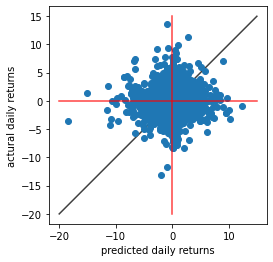

In [147]:
show_prediction_scatter(y_pred, y_test)

# classfication

In [3]:
def classify(x):
    return x >= 0

In [4]:
y_train_c = y_train.map(classify)
y_valid_c = y_valid.map(classify)
y_test_c = y_test.map(classify)
y_train_val_c = y_train_val.map(classify)

In [5]:
def get_confusion_matrix(y_valid, y_pred):
    columns_labels = ["pred_" + str(l) for l in ["negative","positive"]]
    index_labels = ["act_" + str(l) for l in ["negative","positive"]]
    cm = pd.DataFrame(confusion_matrix(y_valid, y_pred, labels=[0,1]),
                      columns=columns_labels, index=index_labels)
    print(cm)

## Bayesian Classifier

In [81]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_std, y_train_c)

GaussianNB()

In [82]:
y_pred = gnb.predict(X_valid_std)
print(classification_report(y_valid_c, y_pred))

              precision    recall  f1-score   support

       False       0.49      0.02      0.05     36760
        True       0.53      0.98      0.69     41313

    accuracy                           0.53     78073
   macro avg       0.51      0.50      0.37     78073
weighted avg       0.51      0.53      0.38     78073



In [83]:
get_confusion_matrix(y_valid_c, y_pred)

              pred_negative  pred_positive
act_negative            867          35893
act_positive            906          40407


## k-nearest neighbor classifer

In [784]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_std, y_train_c)

KNeighborsClassifier(n_neighbors=10)

In [791]:
y_pred = knn.predict(X_valid_std)
print(classification_report(y_valid_c, y_pred))

              precision    recall  f1-score   support

       False       0.52      0.59      0.55     37141
        True       0.58      0.50      0.53     40984

    accuracy                           0.54     78125
   macro avg       0.55      0.55      0.54     78125
weighted avg       0.55      0.54      0.54     78125



In [792]:
get_confusion_matrix(y_valid_c, y_pred)

              pred_negative  pred_positive
act_negative          22075          15066
act_positive          20578          20406


## Decision Tree Classifier

In [446]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_std, y_train_c)

DecisionTreeClassifier(random_state=0)

In [447]:
y_pred = clf.predict(X_valid_std)
print(classification_report(y_valid_c, y_pred))

              precision    recall  f1-score   support

       False       0.63      0.63      0.63     35488
        True       0.67      0.67      0.67     39845

    accuracy                           0.66     75333
   macro avg       0.65      0.65      0.65     75333
weighted avg       0.66      0.66      0.66     75333



In [448]:
get_confusion_matrix(y_valid_c, y_pred)

              pred_negative  pred_positive
act_negative          22526          12962
act_positive          12984          26861


## XGBOOST Classifier

In [449]:
xgbclf = xgboost.XGBClassifier()
xgbclf.fit(X_train_std, y_train_c)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [450]:
y_pred = xgbclf.predict(X_valid_std)
print(classification_report(y_valid_c, y_pred))

              precision    recall  f1-score   support

       False       0.70      0.65      0.67     35488
        True       0.71      0.76      0.73     39845

    accuracy                           0.71     75333
   macro avg       0.71      0.70      0.70     75333
weighted avg       0.71      0.71      0.70     75333



In [451]:
get_confusion_matrix(y_valid_c, y_pred)

              pred_negative  pred_positive
act_negative          22936          12552
act_positive           9614          30231


## SVM Classifier

In [799]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train_std, y_train_c)

In [ ]:
y_pred = xgbclf.predict(X_valid_std)
print(classification_report(y_valid_c, y_pred))

In [ ]:
get_confusion_matrix(y_valid_c, y_pred)

## SGD Classifier

In [174]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train_std, y_train_c)

SGDClassifier()

In [175]:
y_pred = sgd.predict(X_valid_std)
print(classification_report(y_valid_c, y_pred))

              precision    recall  f1-score   support

       False       0.44      0.00      0.01     35223
        True       0.53      1.00      0.69     40056

    accuracy                           0.53     75279
   macro avg       0.48      0.50      0.35     75279
weighted avg       0.49      0.53      0.37     75279



In [176]:
get_confusion_matrix(y_valid_c, y_pred)

              pred_negative  pred_positive
act_negative            147          35076
act_positive            190          39866


# Tuning params

## Tuning XGBOOST

### Optune

In [740]:
model = xgboost.XGBRegressor(booster='gbtree', objective='reg:squarederror',
                     random_state=seed, n_estimators=100,
                     early_stopping_rounds=10, #eval_set=[(X_train_val_std, y_train_val)],
                     #eval_matric='rmse'
                     )

fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(X_train_val_std, y_train_val)]  # early_stopping_roundsの評価指標算出用データ
              }
scoring = 'neg_mean_squared_error'

In [741]:
cv = KFold(n_splits=3, shuffle=True, random_state=seed)  # KFoldでクロスバリデーション分割指定


In [742]:
model.fit(X_train_val_std, y_train_val, **fit_params)

/Users/ryuseitaniguchi/Downloads/stock/venv/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



KeyboardInterrupt: 

In [592]:
model.score(X_test_std, y_test)

0.31947653444968527

In [743]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'subsample': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_alpha': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'reg_lambda': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'learning_rate': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'gamma': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0]
             }
param_scales = {'subsample': 'linear',
                'colsample_bytree': 'linear',
                'reg_alpha': 'log',
                'reg_lambda': 'log',
                'learning_rate': 'log',
                'min_child_weight': 'linear',
                'max_depth': 'linear',
                'gamma': 'log'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X_train_val_std, y=y_train_val,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

KeyboardInterrupt: 

In [597]:
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 13),
        'max_depth': trial.suggest_int('max_depth', 7, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 1, log=True),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.5, log=True),
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X_train_val_std, y_train_val, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=600)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

[I 2022-07-09 16:20:43,095] A new study created in memory with name: no-name-7f716d41-df17-49da-b3a1-24e5cf90cf83
[I 2022-07-09 16:23:02,190] Trial 0 finished with value: -2.7212405219609166 and parameters: {'learning_rate': 0.23688639503640782, 'min_child_weight': 13, 'max_depth': 17, 'colsample_bytree': 0.759195090518222, 'subsample': 0.40921304830970556, 'reg_alpha': 0.002051110418843397, 'reg_lambda': 0.0014936568554617625, 'gamma': 0.1599409170128045}. Best is trial 0 with value: -2.7212405219609166.
[I 2022-07-09 16:24:23,929] Trial 1 finished with value: -2.62042371131905 and parameters: {'learning_rate': 0.3991305878561679, 'min_child_weight': 10, 'max_depth': 7, 'colsample_bytree': 0.9819459112971965, 'subsample': 0.8827098485602951, 'reg_alpha': 0.0026587543983272706, 'reg_lambda': 0.0035113563139704067, 'gamma': 0.00047687854154826123}. Best is trial 1 with value: -2.62042371131905.
[I 2022-07-09 16:26:05,216] Trial 2 finished with value: -2.5804885210930286 and parameters: 

KeyboardInterrupt: 

In [105]:
# got from colab 7・11の夜中にやっった
best_params = {
    'learning_rate': 0.10021086434540676, 
    'min_child_weight': 13, 
    'max_depth': 14, 
    'colsample_bytree': 0.7490481001148587, 
    'subsample': 0.9997637462248894, 
    'reg_alpha': 0.0013412043583032852, 
    'reg_lambda': 0.0007840595362158643, 
    'gamma': 0.00011911773539310345
}

### Final Xgboost

In [106]:
xgb = xgboost.XGBRegressor(
    learning_rate=best_params['learning_rate'],
    min_child_weight=best_params['min_child_weight'],
    max_depth=best_params['max_depth'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
)

In [126]:
xgb.fit(X_train_val_std, y_train_val)
xgb.score(X_test_std, y_test)

0.4260237340617269

In [127]:
#with open('models/jp_xgb_v4.pickle', 'wb') as handle:
#    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
y_pred = xgb.predict(X_test_std)
get_error_metrics(y_pred, y_test)

RMSE = 2.031
MAPE = 38685906660357.750%
MAE = 1.009


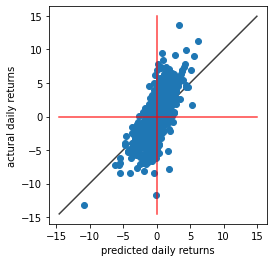

In [129]:
show_prediction_scatter(y_pred, y_test)

In [192]:
y_pred.shape

(300,)

## Tuning: LightGBM

### Before tuning

In [77]:
from lightgbm import early_stopping


model = LGBMRegressor(random_state=seed, n_estimators=100)

fit_params = {'callbacks': [early_stopping(
                  stopping_rounds=10, 
                  verbose=0)],  
              'eval_metric': 'rmse', 
              'eval_set': [(X_train_val_std, y_train_val)]  
              }
cv = KFold(n_splits=3, shuffle=True, random_state=seed)

scoring = 'neg_root_mean_squared_error'
scores = cross_val_score(model, X_train_val_std, y_train_val, cv=cv,
                         scoring=scoring, n_jobs=-1, fit_params=fit_params)

In [471]:
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')

scores=[-1.67733977 -1.67011857 -1.68313762]
average_score=-1.6768653210628288


### Find range to tune

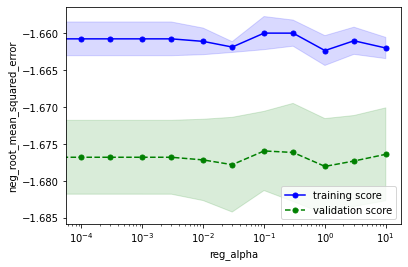

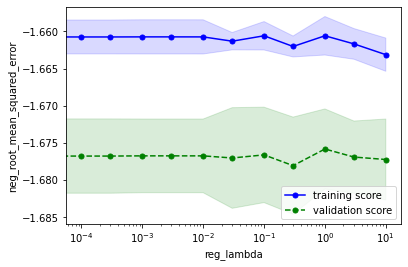

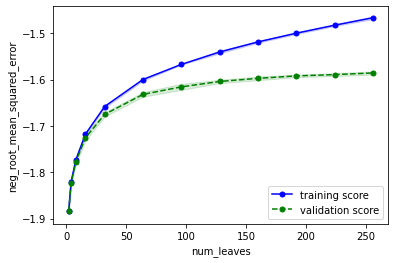

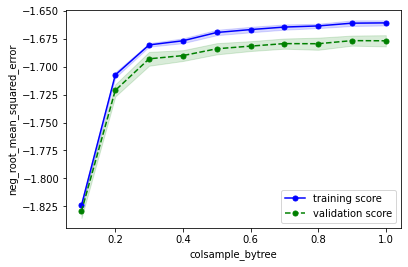

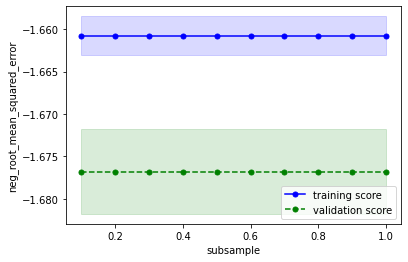

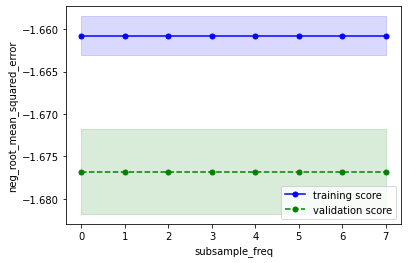

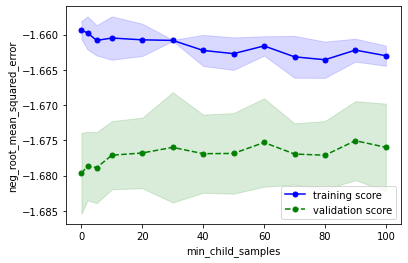

In [78]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X_train_val_std, y=y_train_val,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

### Tuning

In [79]:
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 60, 250),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 80)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X_train_val_std, y_train_val, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

[I 2022-07-10 22:57:39,378] A new study created in memory with name: no-name-a02660f7-aebd-43fa-bfd5-4fcffcc3f5be
[I 2022-07-10 22:57:57,846] Trial 0 finished with value: -1.6036894967724582 and parameters: {'reg_alpha': 0.0074593432857265485, 'reg_lambda': 0.6351221010640696, 'num_leaves': 199, 'colsample_bytree': 0.7190609389379257, 'subsample': 0.4936111842654619, 'subsample_freq': 1, 'min_child_samples': 4}. Best is trial 0 with value: -1.6036894967724582.
[I 2022-07-10 22:58:12,089] Trial 1 finished with value: -1.5992260708014834 and parameters: {'reg_alpha': 2.1423021757741068, 'reg_lambda': 0.02537815508265665, 'num_leaves': 195, 'colsample_bytree': 0.3144091460070617, 'subsample': 0.9819459112971965, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 1 with value: -1.5992260708014834.
[I 2022-07-10 22:58:26,553] Trial 2 finished with value: -1.6094394409864492 and parameters: {'reg_alpha': 0.0008111941985431928, 'reg_lambda': 0.0005415244119402539, 'num_leaves': 118,

最適パラメータ {'reg_alpha': 0.02013394436197334, 'reg_lambda': 0.00017390207646786305, 'num_leaves': 250, 'colsample_bytree': 0.9742373762389176, 'subsample': 0.9848175482506268, 'subsample_freq': 4, 'min_child_samples': 78}
スコア -1.583171397316695
所要時間6260.10894203186秒


In [80]:
#with open('params/lgbm_v4.pickle', 'wb') as handle:
#    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Final LightGBM

In [263]:
with open('params/lgbm_v4.pickle', 'rb') as handle:
    best_params = pickle.load(handle)

In [264]:
lgbm = LGBMRegressor(
    random_state=seed, 
    n_estimators=100,
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    num_leaves=int(best_params['num_leaves']),
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    subsample_freq=best_params['subsample_freq'],
    min_child_samples=int(best_params['min_child_samples']),
)

In [131]:
#lgbm.fit(X_train_val_std, y_train_val)
r2_score(y_test, lgbm.predict(X_test_std))

0.41012780849809993

In [132]:
#with open('models/jp_lgbm_v4.pickle', 'wb') as handle:
#    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [133]:
y_pred = lgbm.predict(X_test_std)
get_error_metrics(y_pred, y_test)

RMSE = 2.087
MAPE = 41010424893116.953%
MAE = 1.023


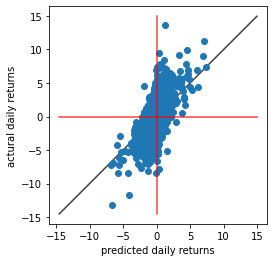

In [134]:
show_prediction_scatter(y_pred, y_test)

## Tuning Random Forest

### Tuning with random search

In [94]:
model = RandomForestRegressor()

parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'max_features': ['log2', 'sqrt', None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10, 15, 20],
    'n_estimators': [130, 180, 230]
}

rf_random = RandomizedSearchCV(
    estimator=model,
    param_distributions=parameters,
    scoring='neg_mean_squared_error',
    n_iter=100, cv=3, verbose=2,
    random_state=42, n_jobs = -1)

In [95]:
rf_random.fit(X_train_val_std, y_train_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time= 7.8min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time= 7.8min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time= 7.8min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time= 6.2min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=130; total time= 6.2min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=230; total time=17.3min
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=20, n_estimators=

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [130, 180, 230]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [96]:
print('Best Score: %s' % rf_random.best_score_)
print('Best Hyperparameters: %s' % rf_random.best_params_)
best_rf = rf_random.best_estimator_
best_params = rf_random.best_params_

Best Score: -2.410649363866636
Best Hyperparameters: {'n_estimators': 180, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 90, 'bootstrap': True}


### Final Random Forest

In [135]:
with open('v4/rf_model.pickle', 'rb') as handle:
    rf = pickle.load(handle)

In [136]:
r2_score(y_test, rf.predict(X_test_std))

0.49946600644992367

In [104]:
y_pred = rf.predict(X_valid_std)
get_error_metrics(y_pred, y_valid)

RMSE = 4.098
MAPE = 63961167414750.977%
MAE = 1.382


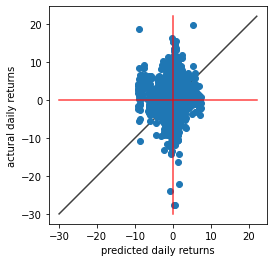

In [105]:
show_prediction_scatter(y_pred, y_valid)

# Stacking

In [154]:
with open('v4/rf_model.pickle', 'rb') as handle:
    rf = pickle.load(handle)

with open('v4/jp_xgb_model.pickle', 'rb') as handle:
    xgb = pickle.load(handle)

with open('v4/jp_lgbm_model.pickle', 'rb') as handle:
    lgbm = pickle.load(handle)


#with open('v4/keras2.pickle', 'rb') as handle:
#    nn = pickle.load(handle)

In [153]:
print(rf.score(X_test_std, y_test))
print(xgb.score(X_test_std, y_test))
print(lgbm.score(X_test_std, y_test))

0.49946600644992367
0.4260237340617269
0.41012780849809993


In [149]:
rf_pred = rf.predict(X_train_val_std)
xgb_pred = xgb.predict(X_train_val_std)
lgbm_pred = lgbm.predict(X_train_val_std)
#nn_pred = nn.predict(X_train_val_std)

In [150]:
results = pd.DataFrame({
    'rf': rf_pred, 'xgb': xgb_pred, 'lgbm': lgbm_pred, #'nn': nn_pred.squeeze()
    })
results.head()

,rf,xgb,lgbm
0,-0.082831,0.098839,0.264616
1,-2.055099,-1.345578,-1.154819
2,0.045223,0.351629,0.508045
3,0.255250,0.270933,0.092323
4,0.620933,0.782935,0.717909


## XGBOOST Stacking

### before tuning

In [90]:
stack = xgboost.XGBRegressor()
stack.fit(results, y_train_val)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [91]:
stack.score(results, y_train_val)

0.6845702501707511

In [123]:
score = cross_val_score(stack, X_train_val_std, y_train_val, cv=5)

In [124]:
score.mean()

0.3108633102863182

In [662]:
#with open('models/stacking.pickle', 'wb') as handle:
#    pickle.dump(stack, handle, protocol=pickle.HIGHEST_PROTOCOL)

### XGBOOST tuning

In [134]:
model = xgboost.XGBRegressor(booster='gbtree', objective='reg:squarederror',
                     random_state=seed, n_estimators=100,
                     early_stopping_rounds=10, #eval_set=[(X_train_val_std, y_train_val)],
                     #eval_matric='rmse'
                     )

fit_params = {'verbose': 0,  # 学習中のコマンドライン出力
              'eval_metric': 'rmse',  # early_stopping_roundsの評価指標
              'eval_set': [(results, y_train_val)]  # early_stopping_roundsの評価指標算出用データ
              }
scoring = 'neg_mean_squared_error'

cv = KFold(n_splits=3, shuffle=True, random_state=seed)  # KFoldでクロスバリデーション分割指定

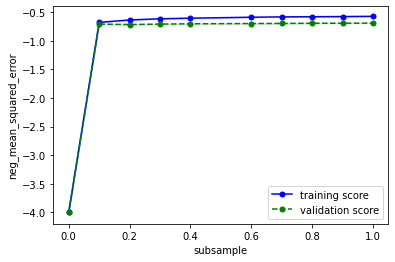

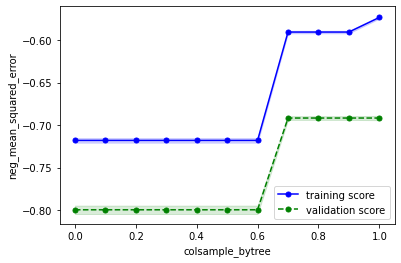

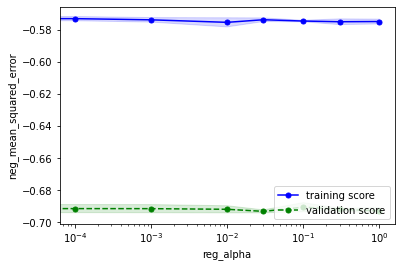

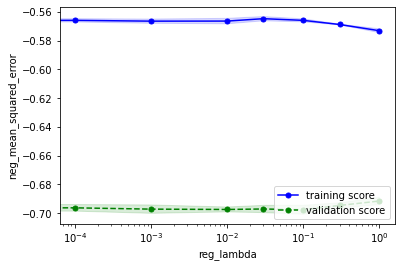

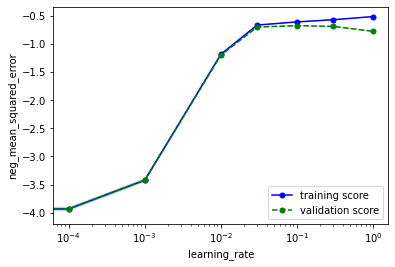

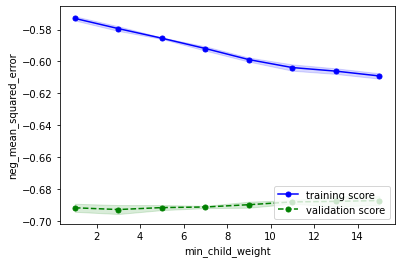

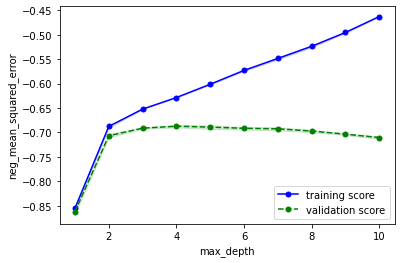

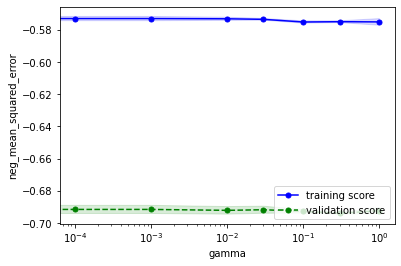

In [135]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'subsample': [0, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'reg_alpha': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'reg_lambda': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'learning_rate': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0],
             'min_child_weight': [1, 3, 5, 7, 9, 11, 13, 15],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'gamma': [0, 0.0001, 0.001, 0.01, 0.03, 0.1, 0.3, 1.0]
             }
param_scales = {'subsample': 'linear',
                'colsample_bytree': 'linear',
                'reg_alpha': 'log',
                'reg_lambda': 'log',
                'learning_rate': 'log',
                'min_child_weight': 'linear',
                'max_depth': 'linear',
                'gamma': 'log'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=results, y=y_train_val,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

In [136]:
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 14),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.5, log=True),
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, results, y_train_val, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

[I 2022-07-11 14:47:20,835] A new study created in memory with name: no-name-b27fde42-598c-4ea7-b893-f712f2880a48
[I 2022-07-11 14:47:40,374] Trial 0 finished with value: -0.6939421223447422 and parameters: {'learning_rate': 0.15355286838886856, 'min_child_weight': 14, 'max_depth': 8, 'colsample_bytree': 0.7993292420985183, 'subsample': 0.24041677639819287, 'reg_alpha': 0.0029375384576328283, 'reg_lambda': 0.00014936568554617635, 'gamma': 0.1599409170128045}. Best is trial 0 with value: -0.6939421223447422.
[I 2022-07-11 14:47:48,980] Trial 1 finished with value: -0.7131247706759396 and parameters: {'learning_rate': 0.30271829277346235, 'min_child_weight': 10, 'max_depth': 2, 'colsample_bytree': 0.9849549260809971, 'subsample': 0.8491983767203796, 'reg_alpha': 0.004335281794951566, 'reg_lambda': 0.0003511356313970409, 'gamma': 0.00047687854154826123}. Best is trial 0 with value: -0.6939421223447422.
[I 2022-07-11 14:48:01,083] Trial 2 finished with value: -1.0669206792313333 and parame

KeyboardInterrupt: 

In [139]:
best_params = {'learning_rate': 0.08688340441021729, 'min_child_weight': 14, 'max_depth': 6, 'colsample_bytree': 0.9805217318516012, 'subsample': 0.4856841281257233, 'reg_alpha': 0.00448771330648101, 'reg_lambda': 0.012509325660279947, 'gamma': 0.0029754083068387668}


In [140]:
model = xgboost.XGBRegressor(
    learning_rate=best_params['learning_rate'],
    min_child_weight=best_params['min_child_weight'],
    max_depth=best_params['max_depth'],
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    gamma=best_params['gamma'],
)

In [146]:
model.fit(results, y_train_val)
#model.score(X_valid_std, y_valid)

ValueError: Feature shape mismatch, expected: 3, got 87

In [142]:
#with open('params/xgb_stack_v4.pickle', 'wb') as handle:
#   pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
#
#with open('models/xgb_stack_v4.pickle', 'wb') as handle:
#   pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [143]:
y_pred = model.predict(results)
get_error_metrics(y_pred, y_train_val)

RMSE = 0.654
MAPE = 44786229349920.945%
MAE = 0.542


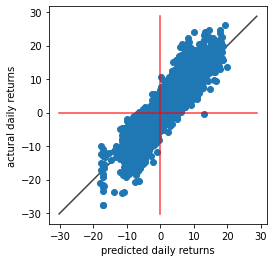

In [145]:
show_prediction_scatter(y_pred, y_train_val)

## Ridge stacking

In [650]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(results, y_valid)

Ridge(alpha=0.1)

In [651]:
score = cross_val_score(ridge, X_train_val_std, y_train_val, cv=5)

In [652]:
score.mean()

0.05282952415696949

In [653]:
with open('models/stacking.pickle', 'wb') as handle:
    pickle.dump(ridge, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [654]:
#rf_test = rf.predict(X_test_std)
#xgb_test = xgb.predict(X_test_std)
#lgbm_test = lgbm.predict(X_test_std)

In [655]:
test = pd.DataFrame({'rf': rf_test, 'xgb': xgb_test, 'lgbm': lgbm_test})

In [656]:
ridge.score(test, y_test)

0.3680635752351915

In [657]:
y_pred = ridge.predict(test)
get_error_metrics(y_pred, y_test)

RMSE = 2.435
MAPE = 54454086631072.680%
MAE = 1.038


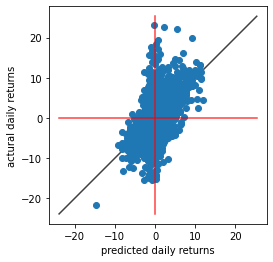

In [658]:
show_prediction_scatter(y_pred, y_test)